<a href="https://colab.research.google.com/github/ChoeTaeBin/Machine-Learnig/blob/main/Airbnb_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 <문제정의>

'비즈니스의 목적이 정확히 무엇인가?'  

-> airbnb에 사용자가 자신의 집을 업로드 할 때 얼마에 올리면 좋을지 추천 해 주는 시스템을 만들자
   aibnb 회사에서는 이 시스템을 이용해서 사용성을 높일 수 있고 제시 가격을 조정함으로써 사용자들의 업로드 가격에 영향을 줄 수 있다.

   추천가격의 최소 단위는 5달러로 한다.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

c:\Users\choetaebin\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [ ]:
pd.set_option("display.max_columns",None) #모든 columns을 보겠다고 설정함

In [ ]:
org_df = pd.read_csv('./Airbnb_Data.csv') #원본데이터

In [ ]:
df = org_df.copy() #조작을 위해서 복사함

#2 <데이터 구조 훑어보기, 특성 가공>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

In [ ]:
df['price'] = np.exp(df['log_price']) #원래 가격 특성도 저장

target인 price(log_price)의 분포는 테스트세트 분리 전 미리 살펴보겠습니다.

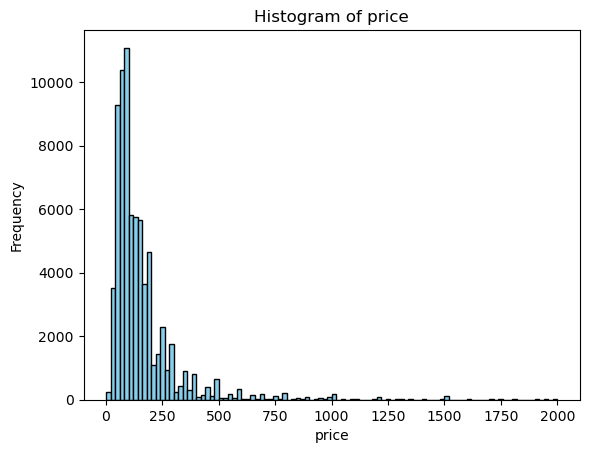

In [ ]:
plt.hist(df['price'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('price')
plt.ylabel('Frequency')
plt.title('Histogram of price')
plt.savefig('price_histogram.png')
plt.show()

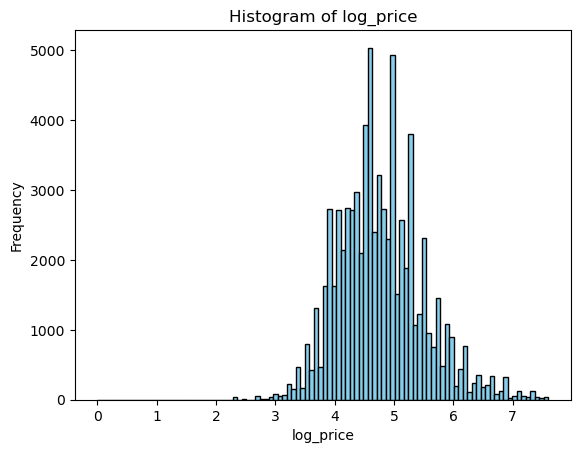

In [ ]:
plt.hist(df['log_price'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('log_price')
plt.ylabel('Frequency')
plt.title('Histogram of log_price')
plt.savefig('log_price_histogram.png')
plt.show()

log를 씌우니 target이 조금더 정규 분포에 가까워 졌습니다.
1. log_price를 target으로 하고 예측결과를 exp취해서 price로 바꾸어 주기
2. price를 target으로 하기

최소 단위가 10달러가 되도록 반올림한 가격을 또 다른 feature로 추가

In [ ]:
df['rounded_price'] = np.round(df['price']/10) * 10

In [ ]:
df[['price', 'rounded_price']]

,price,rounded_price
0,150.0,150.0
1,169.0,170.0
2,145.0,140.0
3,750.0,750.0
4,115.0,120.0
...,...,...
74106,100.0,100.0
74107,155.0,160.0
74108,185.0,180.0
74109,195.0,200.0


반올림 하여 0인 경우는 삭제함 -> 가격이 너무 낮은 것은 다른 이유가 있을 것이므로 모델 학습에 도움이 되지 않는다고 판단 하였습니다.

In [ ]:
df.drop(df.loc[df['rounded_price'] <= 0].index , inplace = True)

In [ ]:
df.shape

(74110, 31)

last review를 업로드 시점으로 근사하여 사용 해 보겠습니다.

In [ ]:
df['last_review'].value_counts

<bound method IndexOpsMixin.value_counts of 0        2016-07-18
1        2017-09-23
2        2017-09-14
3               NaN
4        2017-01-22
            ...    
74106           NaN
74107    2017-04-15
74108    2017-09-10
74109           NaN
74110    2017-04-30
Name: last_review, Length: 74110, dtype: object>

In [ ]:
import datetime

# 문자열을 datetime 형식으로 변환하는 함수 정의
def convert_to_datetime(date_string):
    if pd.isna(date_string):  # NaN 값인 경우
        return date_string   # 그대로 반환
    else:
      return pd.to_datetime(date_string).month

이를 이용해서 몇월인지 추출 해서 month 특성으로 만들 었습니다.

In [ ]:
df['month'] = df['last_review'].apply(convert_to_datetime)

In [ ]:
df['month']

0        7.0
1        9.0
2        9.0
3        NaN
4        1.0
        ... 
74106    NaN
74107    4.0
74108    9.0
74109    NaN
74110    4.0
Name: month, Length: 74110, dtype: float64

amenities는 단어갯수를 세서 num_amenities로 대체했습니다.

In [ ]:
df['num_amenities'] = df['amenities'].apply(lambda x : x.count(',') + 1)

cancellation_policy를 cancellation_strictness라는 새로운  정수형 특성을 만들어서 대체했습니다. 이는 취소가 정책이 엄격할수록 커지는 수 입니다.

In [ ]:
df['cancellation_policy'].value_counts()

cancellation_policy
strict             32373
flexible           22545
moderate           19063
super_strict_30      112
super_strict_60       17
Name: count, dtype: int64

In [ ]:
df.groupby('cancellation_policy')['price'].mean()

cancellation_policy
flexible           150.265336
moderate           141.453706
strict             177.789887
super_strict_30    264.205357
super_strict_60    929.176471
Name: price, dtype: float64

In [ ]:
strictness ={
  'flexible' : -1,
  'moderate' : 0,
  'strict' : 1,
  'super_strict_30' : 2,
  'super_strict_60' : 3
}

df['cancellation_strictness'] = df['cancellation_policy'].map(strictness)

의미가 있을 것으로 생각되는 특성을 몇가지 추가 하겠습니다.

beds / accommodates: 숙박 가능 인원 당 침대 수

의미: 한 사람 당 사용할 수 있는 침대의 수

In [ ]:
df['beds_per_accommodates'] = df['beds'] / df['accommodates']

bathrooms / accommodates: 숙박 가능 인원 당 욕실 수

의미: 숙박 인원 당 욕실의 수는 편의성을 나타낼 수 있음

In [ ]:
df['bathrooms_per_accommodates'] = df['bathrooms'] / df['accommodates']

가격과 관련이 없거나 사용자가 사용시점에서 알 수 없는 feature들은 삭제했습니다.

In [ ]:
df.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds',
       'price', 'rounded_price', 'month', 'num_amenities',
       'cancellation_strictness', 'beds_per_accommodates',
       'bathrooms_per_accommodates'],
      dtype='object')

In [ ]:
dropCols = ['id', 'amenities', 'description', 'first_review', 'host_response_rate', 'host_since', 'last_review', 'name', 'number_of_reviews',  'review_scores_rating', 'thumbnail_url', 'zipcode']
df.drop(columns = dropCols, inplace = True)

In [ ]:
deleted_df = df.dropna()
deleted_df.shape

(52780, 24)

In [ ]:
df = deleted_df #결측치가 있는 샘플은 모두 제거 하겠습니다.

최종적으로 52780개의 sample이 남았습니다.

#3. <test data 분리>  
rounded_price를 이용해서 stratified sampling을 한다

In [ ]:
from sklearn.model_selection import train_test_split

# 'price' 값을 100으로 나누어 새로운 열인 'price_bin'을 추가
df['price_bin'] = (df['rounded_price'] // 100).astype(int)

# 계층적 샘플링을 위해 'price_bin'을 기준으로 데이터를 분할
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['price_bin'], random_state=42)

# 분할 후 'price_bin' 열 삭제
train_data.drop(columns=['price_bin'], inplace=True)
test_data.drop(columns=['price_bin'], inplace=True)

C:\Users\choetaebin\AppData\Local\Temp\ipykernel_33924\3008349067.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_bin'] = (df['rounded_price'] // 100).astype(int)


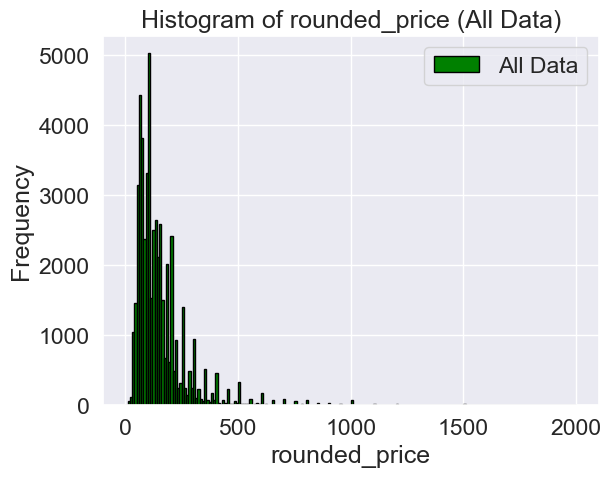

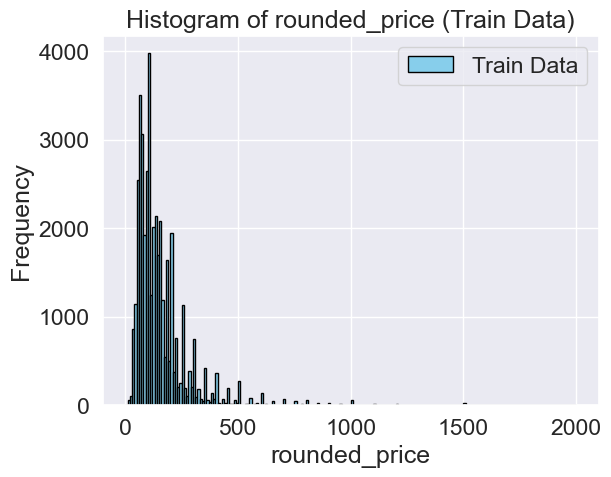

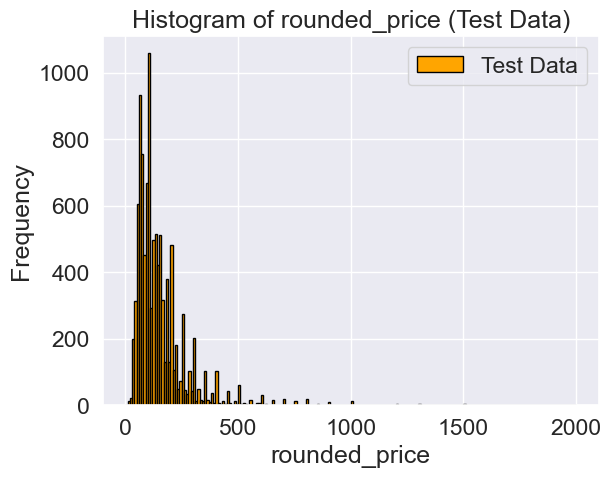

In [ ]:
# 전체 데이터의 히스토그램 그리기
plt.hist(df['rounded_price'], bins=range(0, int(train_data['rounded_price'].max() + 10), 10), color='green', edgecolor='black', label='All Data')
plt.xlabel('rounded_price')
plt.ylabel('Frequency')
plt.title('Histogram of rounded_price (All Data)')
plt.legend()
plt.show()

# 훈련 데이터의 히스토그램 그리기
plt.hist(train_data['rounded_price'], bins=range(0, int(train_data['rounded_price'].max() + 10), 10), color='skyblue', edgecolor='black', label='Train Data')
plt.xlabel('rounded_price')
plt.ylabel('Frequency')
plt.title('Histogram of rounded_price (Train Data)')
plt.legend()
plt.show()

# 테스트 데이터의 히스토그램 그리기
plt.hist(test_data['rounded_price'], bins=range(0, int(train_data['rounded_price'].max() + 10), 10), color='orange', edgecolor='black', label='Test Data')
plt.xlabel('rounded_price')
plt.ylabel('Frequency')
plt.title('Histogram of rounded_price (Test Data)')
plt.legend()
plt.show()


비율을 그대로 유지하면서 잘 나누어 진 것을 볼수 있다.

#4. <데이터 이해를 위한 탐색과 시각화>  
훈련데이터를 더 면밀히 살펴보면 데이터를 이해해 보겠습니다.  

In [ ]:
df_copy = train_data.copy() #조작을 하기위해 복사 함

In [ ]:
import seaborn as sns

# Function to plot catplot graphs
def plot_catplot(df, h, v, he, a):
    sns.set(font_scale=1.5)
    sns.catplot(x=h, kind=v, data=df, height=he, aspect=a)
    plt.show()

# Function to plot pie chart
def plot_piechart(df, column):
    sns.set(font_scale=1.5)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('equal')
    langs = list(df[column].unique())
    students = list(df[column].value_counts())
    ax.pie(students, labels=langs, autopct='%1.2f%%')
    plt.show()

def plot_mean_price_by_category(df, category_column, numeric_column, figsize=(10, 6), alpha=1):
    # 평균 값을 구합니다.
    means = df.groupby(category_column)[numeric_column].mean().reset_index()

    # 그래프 크기 설정
    plt.figure(figsize=figsize)

    # 막대 그래프 그리기
    sns.barplot(x=category_column, y=numeric_column, data=means, alpha=alpha)

    # 평균값을 숫자로 표시합니다.
    for index, row in means.iterrows():
        plt.text(index, row[numeric_column], round(row[numeric_column], 2), color='black', ha="center", va="bottom")

    # 축 레이블과 제목 설정
    plt.xlabel(category_column)
    plt.ylabel(f'Mean {numeric_column}')
    plt.title(f'Mean {numeric_column} by {category_column}')

    # 그래프 표시
    plt.show()

In [ ]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42224 entries, 49326 to 68356
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   log_price                   42224 non-null  float64
 1   property_type               42224 non-null  object 
 2   room_type                   42224 non-null  object 
 3   accommodates                42224 non-null  int64  
 4   bathrooms                   42224 non-null  float64
 5   bed_type                    42224 non-null  object 
 6   cancellation_policy         42224 non-null  object 
 7   cleaning_fee                42224 non-null  bool   
 8   city                        42224 non-null  object 
 9   host_has_profile_pic        42224 non-null  object 
 10  host_identity_verified      42224 non-null  object 
 11  instant_bookable            42224 non-null  object 
 12  latitude                    42224 non-null  float64
 13  longitude                   4222

property_type

In [ ]:
df_copy['property_type'].value_counts()

property_type
Apartment             28495
House                  8956
Condominium            1467
Townhouse               916
Loft                    766
Other                   314
Guesthouse              298
Bed & Breakfast         267
Bungalow                205
Guest suite              81
Dorm                     71
Villa                    66
In-law                   54
Boutique hotel           42
Hostel                   41
Cabin                    38
Boat                     33
Camper/RV                31
Timeshare                27
Castle                   12
Serviced apartment       12
Tent                      7
Treehouse                 5
Vacation home             5
Yurt                      4
Chalet                    3
Hut                       3
Tipi                      2
Cave                      1
Earth House               1
Train                     1
Name: count, dtype: int64

In [ ]:
df_copy['property_type'].nunique()

31

31개의 클래스가 있지만 대부분의 데이터가 Apartment혹은 House에 집중되어있다.

room_type

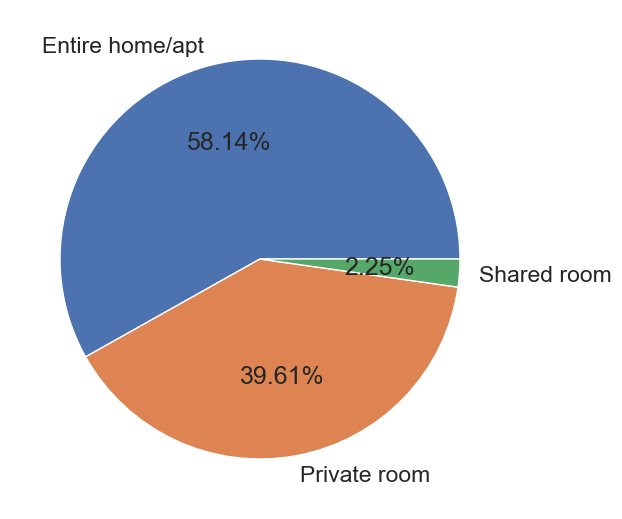

In [ ]:
plot_piechart(df_copy,'room_type')

shared room이 차지 하는 비율은 적은 것을 볼 수 있다. 이 세 클래스간의 가격차이를 살펴보자

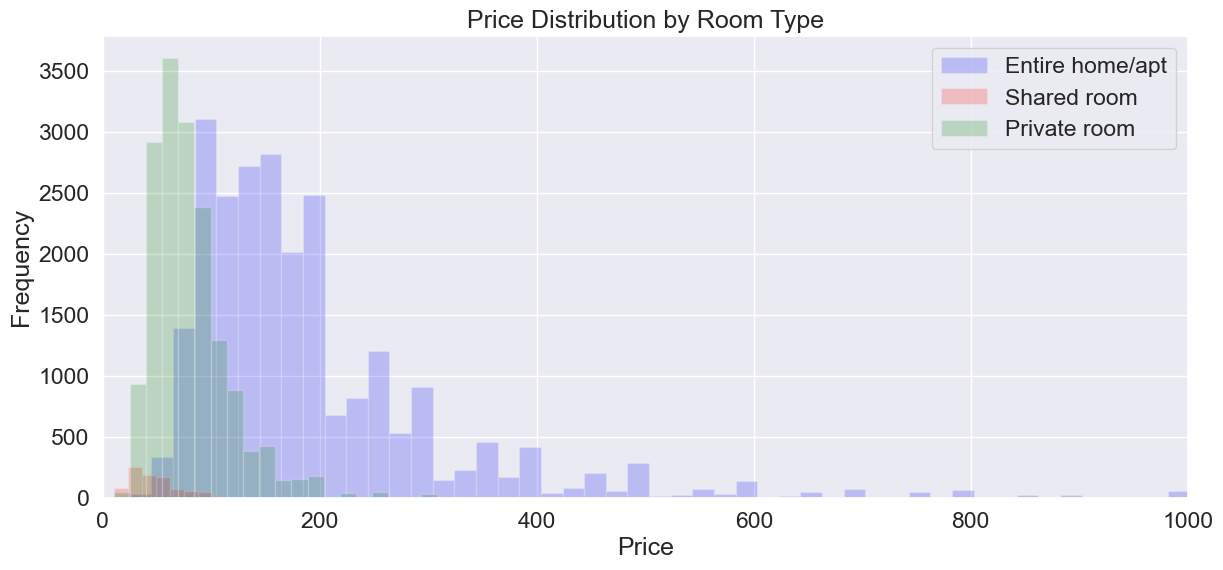

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
# Entire home/apt
plt.hist(df_copy.groupby('room_type').get_group('Entire home/apt')['price'], bins = 100, color='blue', alpha=0.2, label='Entire home/apt')

# Shared room
plt.hist(df_copy.groupby('room_type').get_group('Shared room')['price'], bins = 100, color='red', alpha=0.2, label='Shared room')

# Private room
plt.hist(df_copy.groupby('room_type').get_group('Private room')['price'], bins = 100, color='green', alpha=0.2, label='Private room')

plt.xlim(0, 1000)

plt.title('Price Distribution by Room Type')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

Entire home/apt -> Private room -> Shared room 순으로 평균 가격은 낮아 지는 것을 볼 수 있습니다. 이 특성은 모델이 가격을 예측하는데 중요하게 사용 될 것으로 예상할 수 있습니다.

city

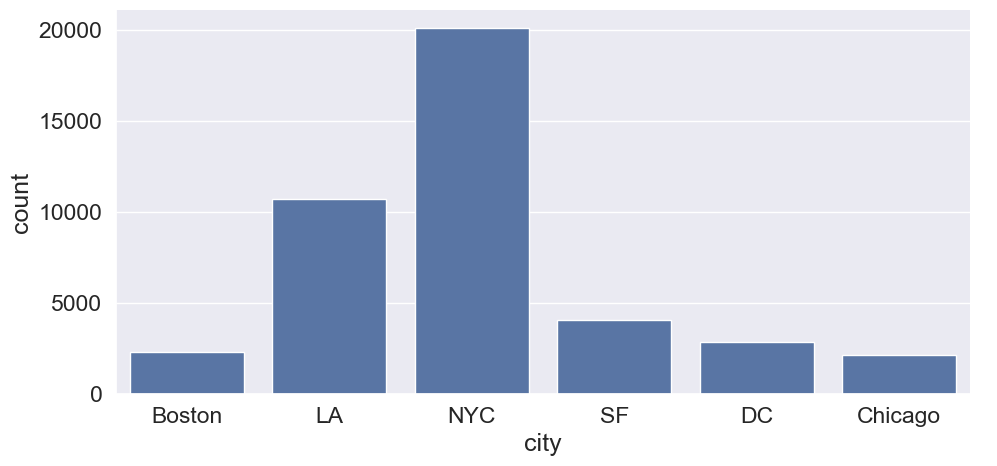

In [ ]:
plot_catplot(df_copy,"city","count", 5, 2)

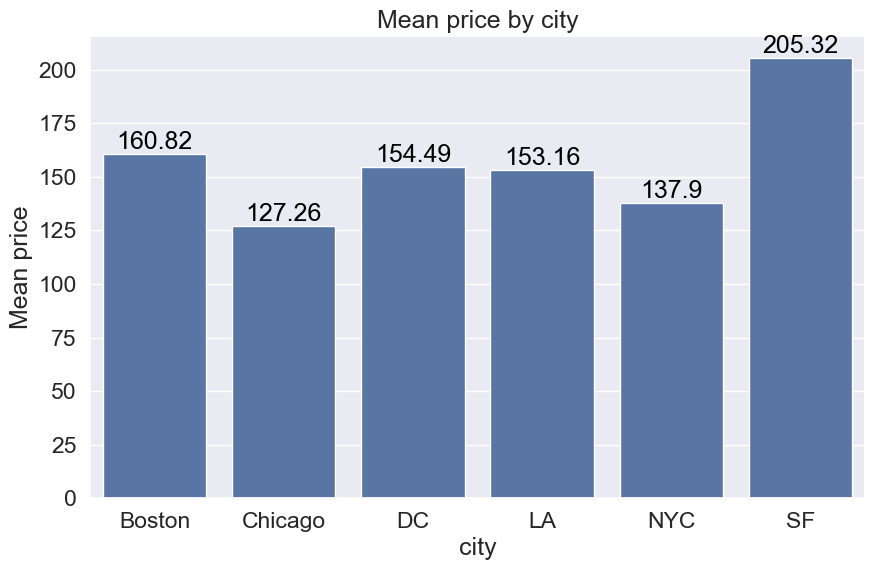

In [ ]:
plot_mean_price_by_category(df_copy,'city', 'price')

도시마다 가격의 평균이 꽤 차이가 있으므로 이 특성도 의미있을 것으로 판단됩니다.

cancellation policy

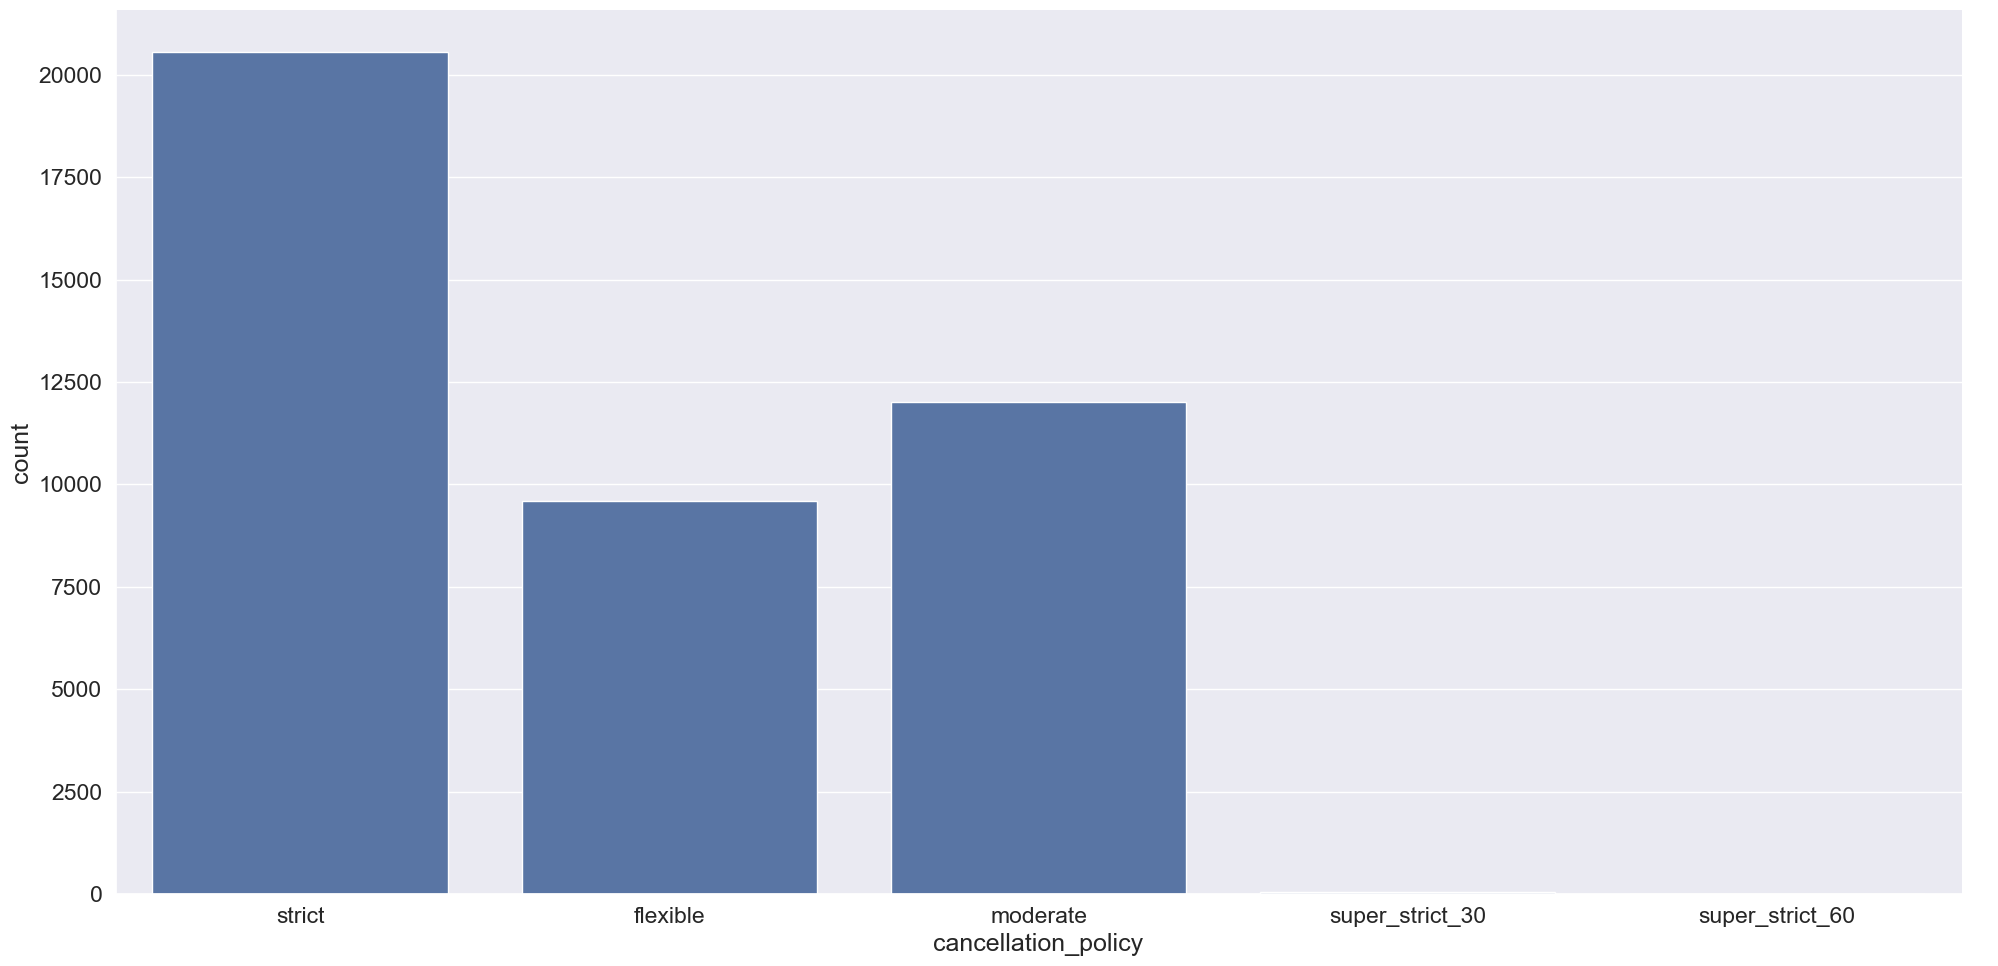

In [ ]:
plot_catplot(df_copy,"cancellation_policy","count",10, 2)

super_strict_30, super_strict_60의 수가 매우 적은 것을 알 수 있다.

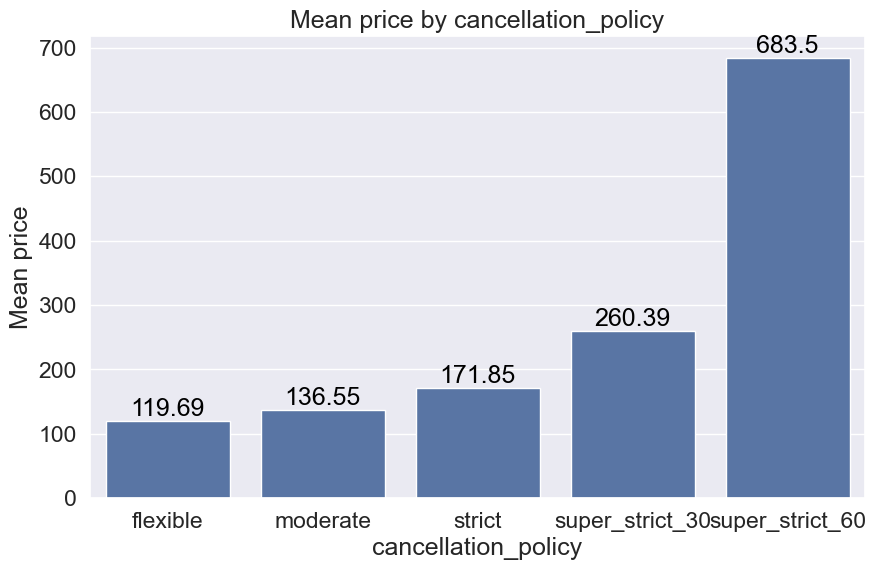

In [ ]:
plot_mean_price_by_category(df_copy,'cancellation_policy', 'price')

엄격할수록 더 가격이 높아지는 양상이 있는 것일까?

In [ ]:
df_copy['cancellation_strictness'].corr(df_copy['price'])

0.16416825426349546

엄격도와 가격간의 선형적인 상관관계는 적은 것으로 보인다.

accommodates

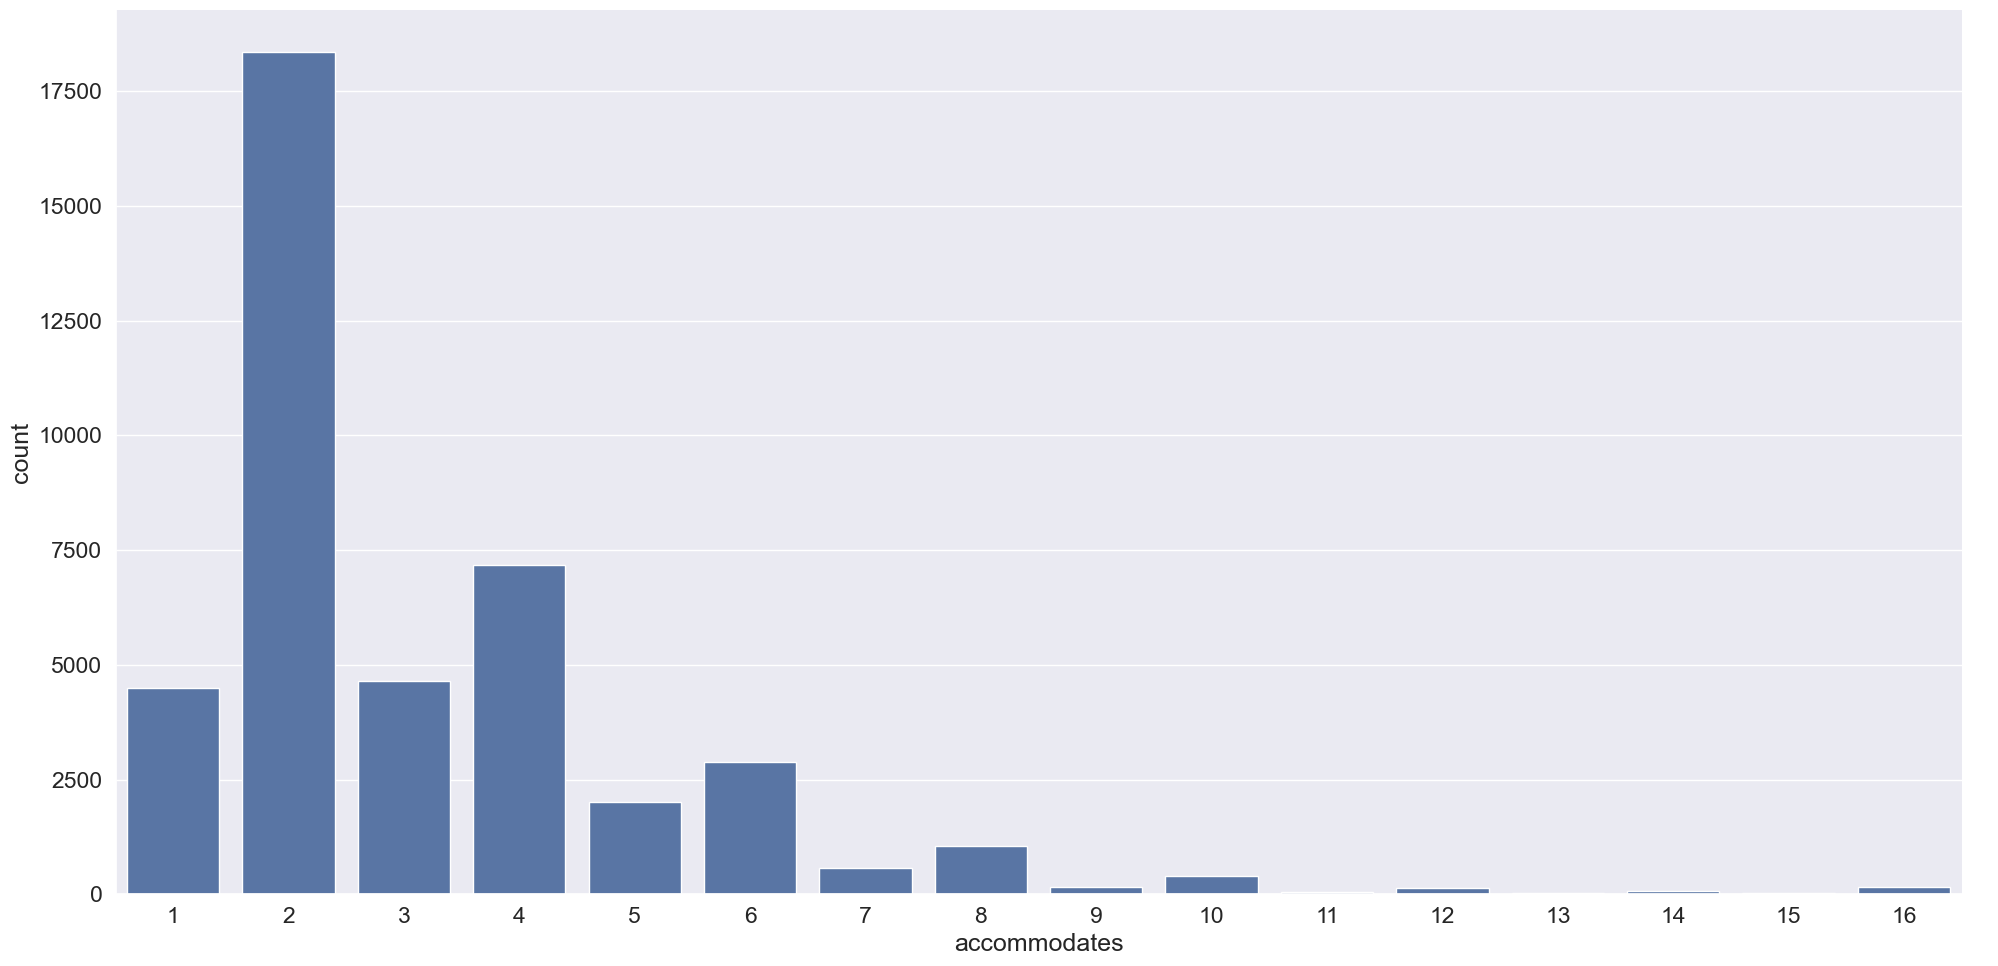

In [ ]:
plot_catplot(df_copy,"accommodates","count",10, 2)

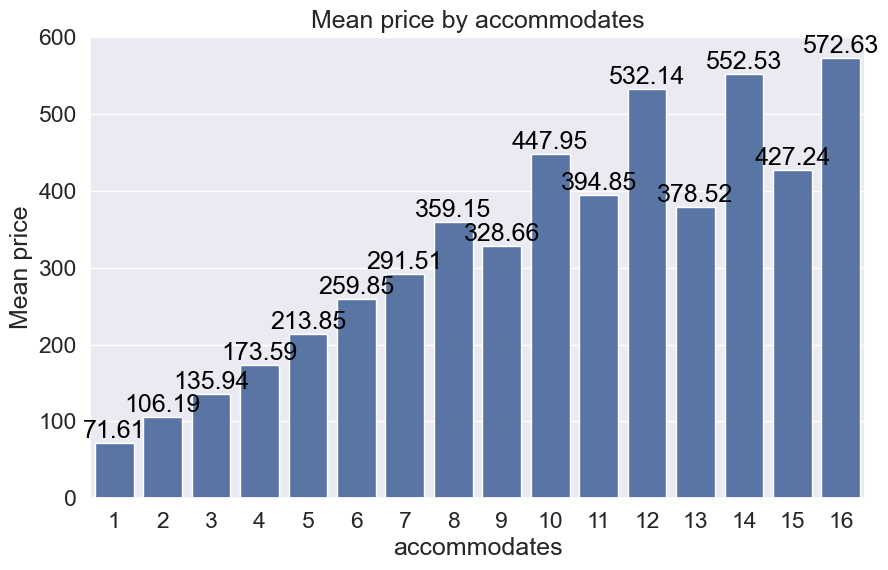

In [ ]:
plot_mean_price_by_category(df_copy,'accommodates', 'price')

수용인원이 늘어 날수록 가격의 평균은 늘어나는 경향을 보인다.
하지만 8인 수용보다 9인수용보다 가격의 평균이 더 낮게 나오는 등 완전이 선형적인 관계는 아니다.

In [ ]:
df_copy['accommodates'].corr(df_copy['price'])

0.5855324353200868

가격과 꽤 높은 상관 계수를 갖는것을 볼수있다.

neighbourhood

In [ ]:
df_copy['neighbourhood'].value_counts()

neighbourhood
Williamsburg          1770
Bedford-Stuyvesant    1384
Bushwick               980
Mid-Wilshire           887
Harlem                 861
                      ... 
West Town                1
Castleton Corners        1
Skyland                  1
Mission Hills            1
O'Hare                   1
Name: count, Length: 584, dtype: int64

In [ ]:
df_temp = df_copy.loc[df_copy['neighbourhood'].isin(df_copy['neighbourhood'].value_counts()[:10].index)] #상위 10개

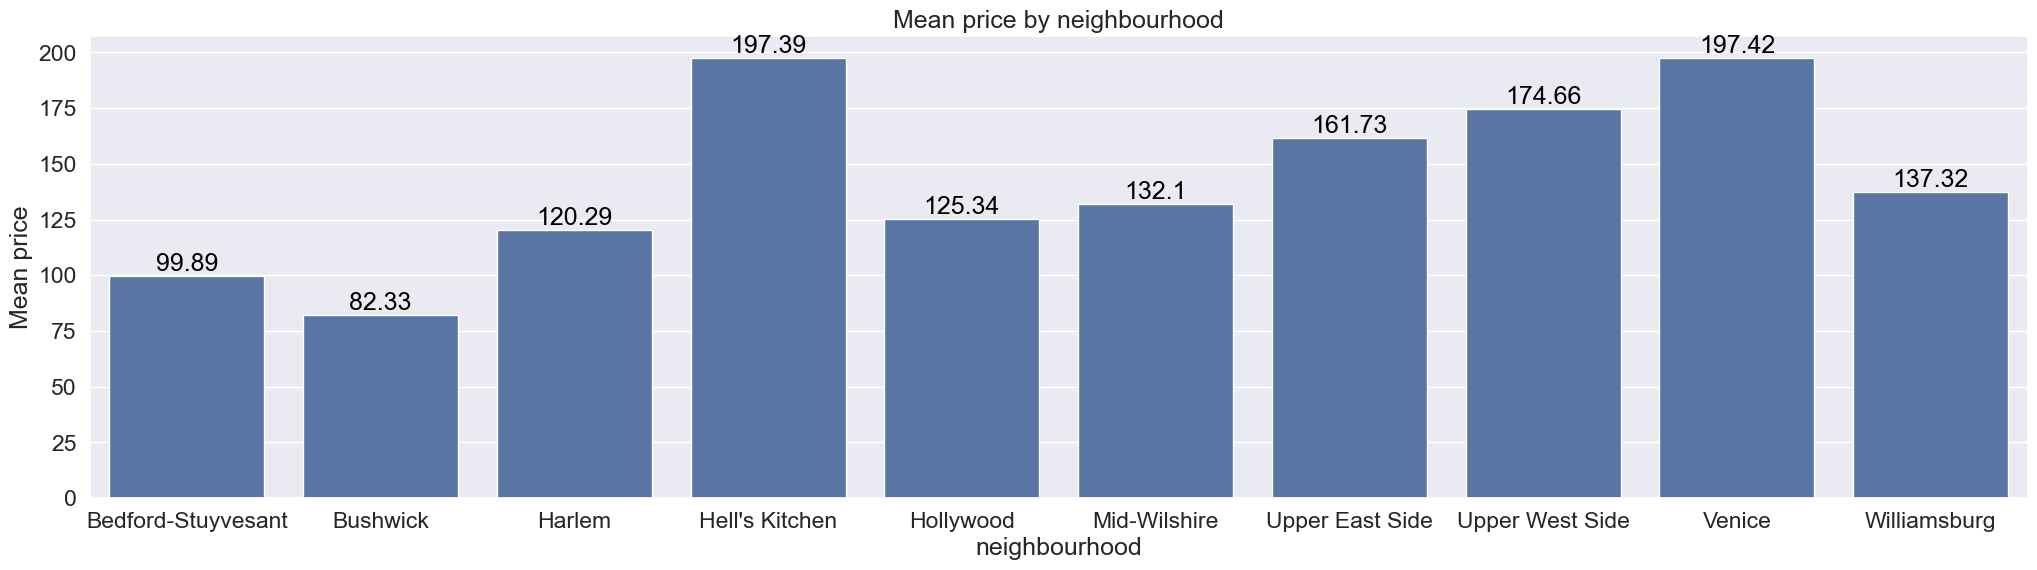

In [ ]:
plot_mean_price_by_category(df_temp,'neighbourhood', 'price',(25,6))

빈도 상위 10개의 neighbourhood를 뽑아서 평균가격을 비교 해 보았습니다. neighbourhood별로 가격이 꽤 차이가 있는 것으로 보입니다.

히트맵

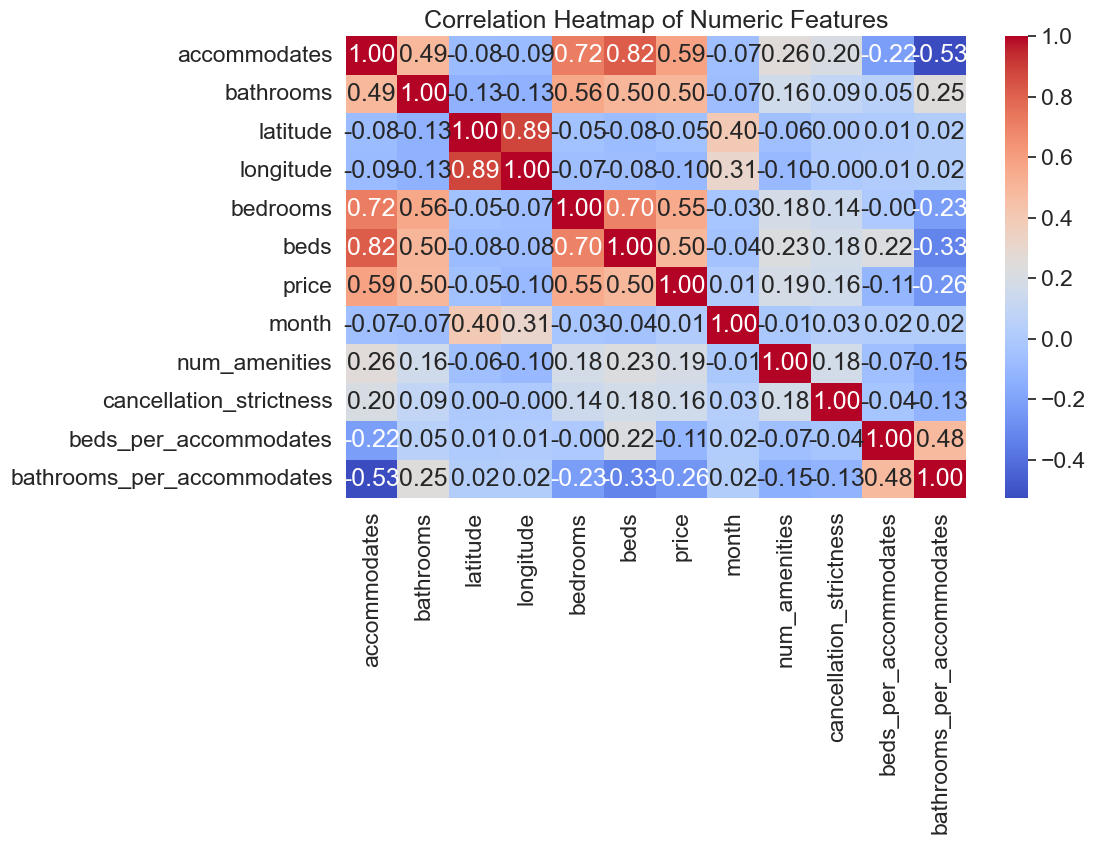

In [ ]:
import seaborn as sns

# train_df에서 숫자형 열만 선택
df_corr = df_copy.drop(columns = ['log_price', 'rounded_price'])
numeric_cols = df_corr.select_dtypes(include='number')

# 숫자형 열 간의 상관 관계 계산
correlation_matrix = numeric_cols.corr()

# 히트맵 생성
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

accommodates, bathrooms, bedrooms, beds등이 price와 비교적 높은 상관계수를 보였고 이들은 모두 서로 높은 상관관계를 가지 것으로 나타났습니다.(독립적이지 않음)

#5. <데이터 전처리>

categorical은 ordinalencoder로 encoding(모르는 값은 최빈값으로 처리) -> standard scaler로 scaling
numeric은 바로 standard scaler롤 scaling

In [ ]:
X_train = train_data.drop(columns = ['price', 'log_price', 'rounded_price'])
X_test = test_data.drop(columns = ['price', 'log_price', 'rounded_price'])

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

cat_pipeline = Pipeline([
    ('encode', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = np.nan)), #처음보는 값은 nan으로 하고
    ('impute',  make_pipeline(SimpleImputer(strategy = 'most_frequent'))), #이후 최빈값으로 바꿈
    ('scaler', scaler)
])

# 전처리 파이프라인 구성
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline,  X_train.columns[X_train.dtypes == 'object']),
    ('num', scaler, X_train.columns[X_train.dtypes != 'object'])  # 숫자형 특성은 그대로 유지
])

# 전처리 파이프라인 훈련
preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encode',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('impute',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))])),
                                                 ('scaler', StandardScaler())]),
                                 Index(['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city',
       'host_has_profile_pic', 'host_identity_verified', 'instant_bookable',
       'neighbourhood'],
      dtype='object')),
                                ('num', StandardScaler(),
                                 Index(['accommodates', 'bathrooms', 'cleaning_fee', 'latitude', 'longitude',
       'bedrooms', 'beds', 'month', 'num_amenities', 'cancellation_strictness',
       'beds_per_accommodates', 'bathrooms_per_accommodates'],
      dtype='object'))])

In [ ]:
columns = np.concatenate([X_train.columns[X_train.dtypes == 'object'],X_train.columns[X_train.dtypes != 'object']]) #열 이름

In [ ]:
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

#데이터 프레임으로 감싸 준다
X_train = pd.DataFrame(X_train, columns = columns)
X_test = pd.DataFrame(X_test, columns = columns)

#6. <모델 학습, 평가>

우선 price를 그대로 target으로 사용 해 보겠습니다.

In [ ]:
y_train = train_data['price']
y_test = test_data['price']

xgboost로 변수중요도를 구해 보았습니다.

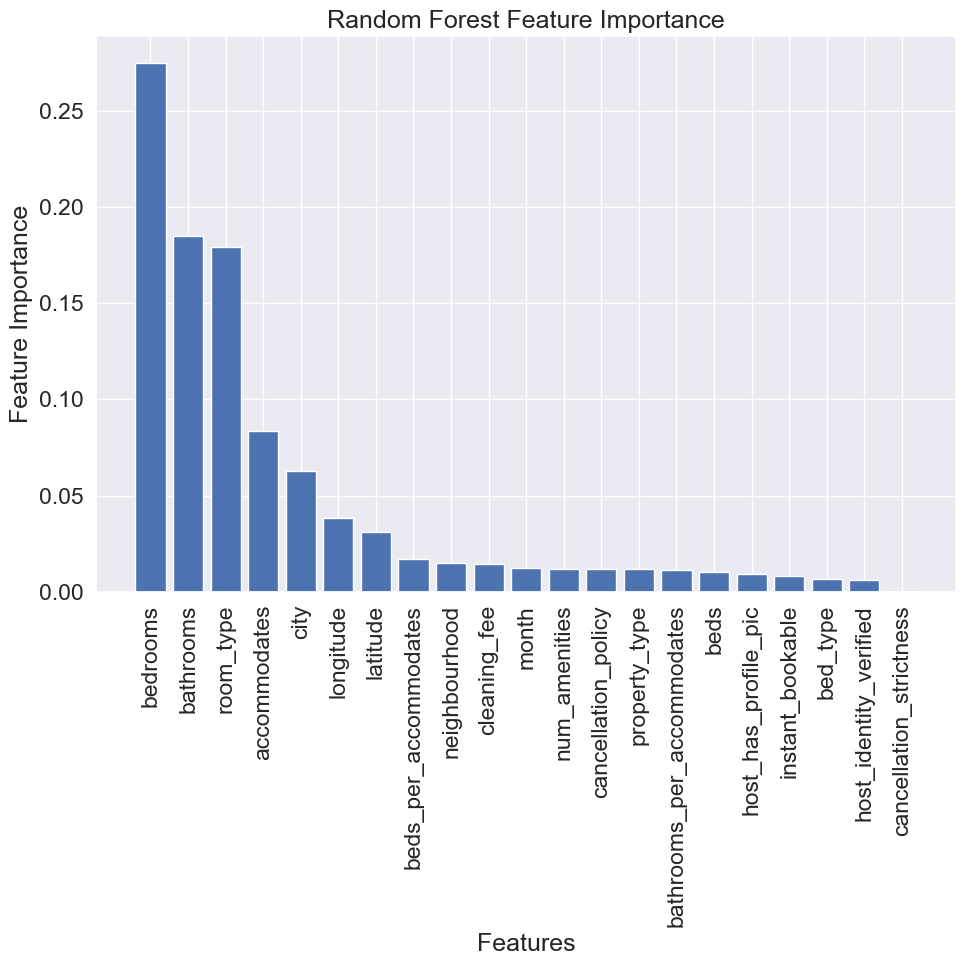

0.5994890957148427


In [ ]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error

# XGBoost 회귀 모델 생성 및 학습
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# 특성 중요도 얻기
feature_importance = xgb_model.feature_importances_

#특성 이름 리스트
feature_names = columns

# 중요도가 높은 특성부터 내림차순으로 정렬합니다.
sorted_idx = feature_importance.argsort()[::-1]

# 특성 중요도를 그래프로 그립니다.
plt.figure(figsize=(10, 10))
plt.bar(range(len(feature_importance)), feature_importance[sorted_idx])
plt.xticks(range(len(feature_importance)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

print(r2_score(y_test, xgb_model.predict(X_test)))

bedrooms, bathrooms등 방의 갯수와 관련되 특징이 중요하게 사용된 것을 볼 수 있습니다.  
또 room type이 앞에서 예상한 대로 중요하게 사용된 것을 확인 하였습니다.    
추가로 city, longitued, latitude등 위치관련 정보들도 판단에 어느정도 사용된 것을 볼 수 있습니다.  
이후 shaply value를 계산하여 이 부분을 다시 살 펴 보겠습니다.  

여러가지 모델을 테스트 해 보고 성능을 비교 해 보겠습니다.

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Calculate RMSE and R² for each model
def evaluate_model(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2


# Instantiate the models
elastic_net = ElasticNet()
random_forest = RandomForestRegressor()
xgboost = XGBRegressor()
catboost = CatBoostRegressor(verbose=0)

# Fit the models
elastic_net.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
xgboost.fit(X_train, y_train)
catboost.fit(X_train, y_train)

# Predict with the models
y_pred_elastic_net = elastic_net.predict(X_test)
y_pred_random_forest = random_forest.predict(X_test)
y_pred_xgboost = xgboost.predict(X_test)
y_pred_catboost = catboost.predict(X_test)


results = {
    'Elastic Net': evaluate_model(y_test, y_pred_elastic_net),
    'Random Forest': evaluate_model(y_test, y_pred_random_forest),
    'XGBoost': evaluate_model(y_test, y_pred_xgboost),
    'CatBoost': evaluate_model(y_test, y_pred_catboost)
}

# Display the results
for model_name, (rmse, r2) in results.items():
    print(f"{model_name} - RMSE: {rmse:.4f}, R²: {r2:.4f}")

Elastic Net - RMSE: 100.9589, R²: 0.4439
Random Forest - RMSE: 85.7448, R²: 0.5989
XGBoost - RMSE: 85.6826, R²: 0.5995
CatBoost - RMSE: 84.2701, R²: 0.6126


CatBoost를 이용한 모델이 제일 좋은 성능을 보여 주었습니다.

이번에는 target을 log_price로 하여 모델을 훈련시키고 평가 해 보겠습니다.

In [ ]:
y_train = train_data['log_price']
y_test = test_data['log_price']

In [ ]:
# Instantiate the models
elastic_net = ElasticNet()
random_forest = RandomForestRegressor()
xgboost = XGBRegressor()
catboost = CatBoostRegressor(verbose=0)

# Fit the models
elastic_net.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
xgboost.fit(X_train, y_train)
catboost.fit(X_train, y_train)

# Predict with the models
y_pred_elastic_net = elastic_net.predict(X_test)
y_pred_random_forest = random_forest.predict(X_test)
y_pred_xgboost = xgboost.predict(X_test)
y_pred_catboost = catboost.predict(X_test)

# Calculate RMSE and R² for each model
def evaluate_model(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

results = {
    'Elastic Net': evaluate_model(y_test, y_pred_elastic_net),
    'Random Forest': evaluate_model(y_test, y_pred_random_forest),
    'XGBoost': evaluate_model(y_test, y_pred_xgboost),
    'CatBoost': evaluate_model(y_test, y_pred_catboost)
}

# Display the results
for model_name, (rmse, r2) in results.items():
    print(f"{model_name} - RMSE: {rmse:.4f}, R²: {r2:.4f}")

Elastic Net - RMSE: 0.6623, R²: -0.0000
Random Forest - RMSE: 0.3466, R²: 0.7262
XGBoost - RMSE: 0.3414, R²: 0.7344
CatBoost - RMSE: 0.3369, R²: 0.7412


여기서도 CatBoost가 가장 높은 성능을 보였습니다.

실제 저희의 시스템에서 log_price가아닌 price를 사용할 것이므로 이를 기준으로 평가해야 합니다.

In [ ]:
y_test = test_data['price']
y_pred = np.exp(catboost.predict(X_test))
rmse, r2 = evaluate_model(y_test, y_pred)
print(f"{model_name} - RMSE: {rmse:.4f}, R²: {r2:.4f}")

CatBoost - RMSE: 83.7888, R²: 0.6170


target에 log를 씌워서 가우스 분포 형태로 만들어 주니 성능이  소폭 향상 된 것을 볼 수 있습니다.  

저희는 가격 추천 모델을 만들 것이므로 모델이 실제 예측한 172.6달러 보다 10달러 단위로 반올림한 170달러가 사용자에게 더 필요한 정보 일 수 있습니다.  
따라서 10달러 단위로 반올림 해 보고 이를 기준으로 평가했을때 점수가 더 높게 나오는지 살펴보겠습니다.

In [ ]:
#최소단위를 10으로 할때
rounded_y_test = test_data['rounded_price']
rounded_y_pred = np.round(np.exp(catboost.predict(X_test))/10)*10
rmse, r2 = evaluate_model(rounded_y_test, rounded_y_pred)
print(f"{model_name} - RMSE: {rmse:.4f}, R²: {r2:.4f}")

CatBoost - RMSE: 83.9037, R²: 0.6163


오히려 성능이 떨어젔습니다. 따라서 저희 시스템에서는 예측값을 사용자에게 그대로 전달 하겠습니다.

결론적으로 log_price를 target으로 학습시키고 출력할때 변환하여 그대로 제시하는 것이 가장 좋은 성능을 보여 주는 것으로 나타났습니다.  
random search를 이용하여 조금더 성능을 높여 보겠습니다.

In [ ]:
y_train = train_data['log_price'] #학습은 log_price로
y_test = test_data['price'] #test는 price기준

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import joblib

# 파라미터 분포 정의
param_distributions = {
    'iterations': [100, 200, 300, 400, 500],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 50, 100]
}

# 모델 초기화
regressor = CatBoostRegressor(verbose=0)

# RandomizedSearchCV 초기화
random_search = RandomizedSearchCV(estimator=regressor, param_distributions=param_distributions, n_iter=50, cv=3, verbose=1, n_jobs=-1, random_state=42)

# 모델 학습
random_search.fit(X_train, y_train)

# 최적의 파라미터 출력
best_params = random_search.best_params_
print("최적의 파라미터: ", best_params)

# 최적의 모델 저장
best_model = random_search.best_estimator_
joblib.dump(best_model, 'best_catboost_model.pkl')
print("최적의 모델이 'best_catboost_model.pkl'에 저장되었습니다.")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
최적의 파라미터:  {'learning_rate': 0.1, 'l2_leaf_reg': 9, 'iterations': 400, 'depth': 10, 'border_count': 100}
최적의 모델이 'best_catboost_model.pkl'에 저장되었습니다.


In [ ]:
y_pred = np.exp(best_model.predict(X_test))
rmse, r2 = evaluate_model(y_test, y_pred)
print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

RMSE: 84.0415, R²: 0.6147


디폴트값보다 더 좋은 성능을 내는 값을 찾지 못했습니다. 따라서 default값을 그대로 사용하겠습니다.

In [ ]:
best_model = CatBoostRegressor(verbose=0)
best_model.fit(X_train, y_train)

예측과정을 더 깊이 있게 이해하기위해서 SHAP값을 구해 보았습니다.

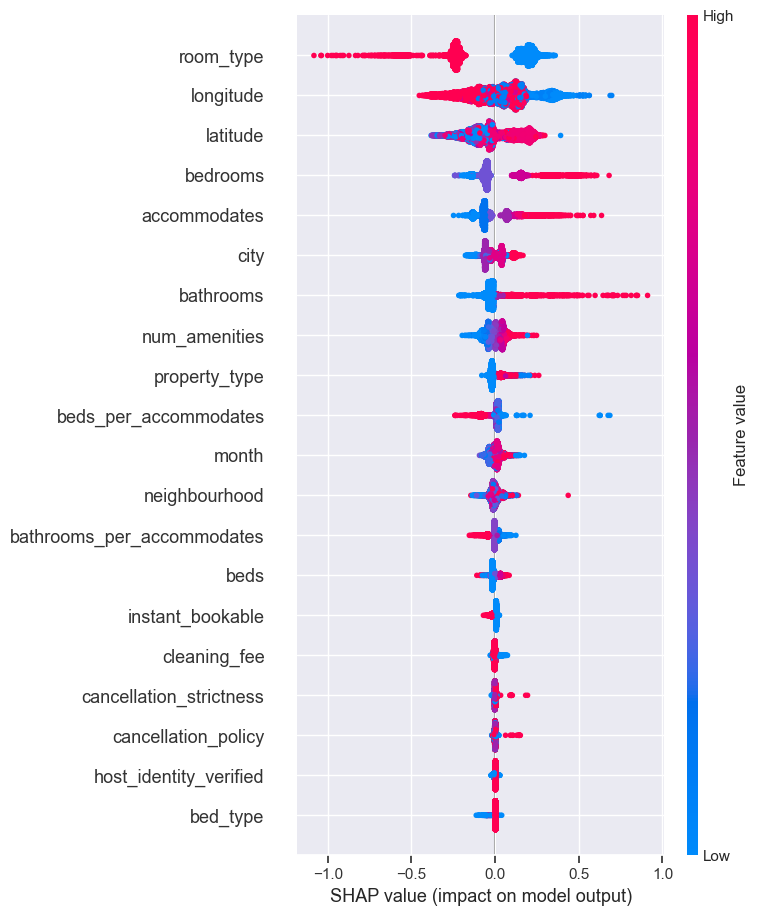

In [ ]:
import shap

explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

roomtype이 중요하게 작용한 다는 것을 다시한번 확인 할 수 있었고 accomodate, bedrooms, bathrooms 등이 높을수록 가격이 높아진다는 것을 알 수 있었습니다

최종결과: 저희 모델은 catboost를 이용하여 log_price를 예측한 후 이를 price로 변환하는 방식으로 추천가격을 출력합니다.  
이 예측값은 실제 값 대비 84달러 정도의 오차를 보여주었습니다.

#8. <최종 모델 pipline으로 묶기>

In [ ]:
X_train = train_data.drop(columns = ['price', 'log_price', 'rounded_price'])
y_train = train_data['log_price']
X_test = test_data.drop(columns = ['price', 'log_price', 'rounded_price'])
y_test = test_data['price']

In [ ]:
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(verbose=0))
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encode',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('impute',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent'))])),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['property_type', 'room_type', 'bed_type', 'cancellation_policy...
       'host_has_profile_pic', 'host_identity_verified', 'instant_bookable',
       'neighbourhood'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['accommodates', 'bathrooms', 'cleaning_fee', 'latitude', 'longitude',
       'bedrooms', 'beds', 'month', 'num_amenities', 'cancellation_strictness',
       'beds_per_accommodates', 'bathrooms_per_accommodates'],
      dtype='object'))])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x0000024D8F92E040>)])

In [ ]:
y_pred = np.exp(model.predict(X_test))
rmse, r2 = evaluate_model(y_test, y_pred)
print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

RMSE: 83.7888, R²: 0.6170


모델 예측 시물레이션

In [ ]:
aUser = test_data[101:102] #사용자
aUser

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_has_profile_pic,host_identity_verified,instant_bookable,latitude,longitude,neighbourhood,bedrooms,beds,price,rounded_price,month,num_amenities,cancellation_strictness,beds_per_accommodates,bathrooms_per_accommodates
47719,4.094345,Apartment,Private room,2,2.0,Real Bed,strict,False,NYC,t,t,t,40.701951,-73.926335,Bushwick,1.0,1.0,60.0,60.0,9.0,19,1,0.5,1.0


In [ ]:
predPrice = np.exp(model.predict(aUser))
realPrice = y_test[101:102].values

print(f"실제 가격 : {realPrice} 예측 가격 : {predPrice}")

실제 가격 : [60.] 예측 가격 : [60.52594405]
